# Data Preprocess

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

Set random seed for reproducibility


In [2]:
torch.manual_seed(42)


Define the data directory paths


In [3]:
train_data_dir =  '/home/yqx/Q3/data/train'
test_data_dir =  '/home/yqx/Q3/data/test'

Define the transformations applied to the images


In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),# Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize image pixels
])


Load the train and test datasets


In [5]:
train_dataset = ImageFolder(train_data_dir, transform=transform)
test_dataset = ImageFolder(test_data_dir, transform=transform)

Create data loaders

In [6]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model


Load the pre-trained ResNet model

In [7]:
model = resnet50(pretrained=True)

/root/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/root/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Modify the fully connected layer for our task


In [8]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

Define the loss function and optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model


In [10]:
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)# move the model to the device whether GPU  or CPU

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0

    model.train()  # Set the model to training mode
    for images, labels in train_loader:
        images = images.to(device)  # Move images to the device (GPU if available)
        labels = labels.to(device)  # Move labels to the device (GPU if available)

        optimizer.zero_grad()  # Clear the gradients from previous iteration

        outputs = model(images)  # Forward pass to get the predicted outputs
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation to compute the gradients
        optimizer.step()  # Update the model parameters using the gradients

        _, predicted = torch.max(outputs, 1)  # Get the predicted labels
        train_correct += (predicted == labels).sum().item()  # Count the number of correct predictions
        train_loss += loss.item() * images.size(0)  # Accumulate the loss

    train_accuracy = 100.0 * train_correct / len(train_dataset)  # Calculate training accuracy
    train_loss /= len(train_dataset)  # Calculate average training loss

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

Epoch 1/10
Train Loss: 0.1557, Train Accuracy: 93.83%
Epoch 2/10
Train Loss: 0.0888, Train Accuracy: 96.62%
Epoch 3/10
Train Loss: 0.0732, Train Accuracy: 97.29%
Epoch 4/10
Train Loss: 0.0580, Train Accuracy: 97.85%
Epoch 5/10
Train Loss: 0.0483, Train Accuracy: 98.21%
Epoch 6/10
Train Loss: 0.0413, Train Accuracy: 98.47%
Epoch 7/10
Train Loss: 0.0361, Train Accuracy: 98.67%
Epoch 8/10
Train Loss: 0.0308, Train Accuracy: 98.88%
Epoch 9/10
Train Loss: 0.0295, Train Accuracy: 98.88%
Epoch 10/10
Train Loss: 0.0261, Train Accuracy: 99.03%


# Evaluate the model on the test set


In [11]:
model.eval()  # Set the model to evaluation mode

test_correct = 0
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)  # Move images to the device (GPU if available)
        labels = labels.to(device)  # Move labels to the device (GPU if available)

        outputs = model(images)  # Forward pass to get the predicted outputs
        _, predicted = torch.max(outputs, 1)  # Get the predicted labels
        test_correct += (predicted == labels).sum().item()  # Count the number of correct predictions

        predictions.extend(predicted.tolist())  # Collect predicted labels
        true_labels.extend(labels.tolist())  # Collect true labels

test_accuracy = 100.0 * test_correct / len(test_dataset)  # Calculate test accuracy

print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 96.81%


# Compute and print the confusion matrix


Confusion Matrix:
[[9598  402]
 [ 237 9763]]


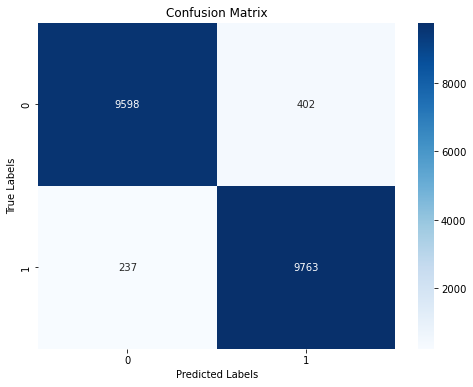

In [14]:
import seaborn as sns
# Compute and print the confusion matrix
confusion_mat = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(confusion_mat)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()